In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from scipy.special import logsumexp
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.signal import stft
from scipy.special import expit

import divebomb

import time
import pickle

# Pick Parameters

In [2]:
crude_timescale = 10 # in minutes
step_size = 2 # in seconds
nperseg = int(step_size*50) # number of samples in a window of stft

N = 3 # number of possible production states S_i
dims = ['Vz','A']
low_high_cutoff = 5 #hertz
accel_ind = 1
d = len(dims) # dimension of Y_t

K = 2 # number of internal states H_i 

diff_norms = False # Should each crude state have its own emission distributions?

# Load in the dataframe

In [3]:
cols = ['date','time',
        'GPS lat','GPS long','GPS alt','GPS speed',
        'quats0','quats1','quats2','quats3',
        'acc x','acc y','acc z',
        'gyro x','gyro y','gyro z',
        'mag x','mag y','mag z',
        'mag cal x','mag cal y','mag cal z',
        'dyn acc x','dyn acc y','dyn acc z',
        'press','pitot speed','GPS num sat',
        'roll','pitch','yaw']

df = pd.read_csv('../Data/20190902-182840-CATs_OB_1.cvc',
                 skiprows=[0],names=cols,encoding='cp1252')

df = df.merge(pd.read_csv('../Data/20190902-182840-CATs_OB_1_001.csv',encoding='cp1252'),
              right_on = ['Date (UTC)', 'Time (UTC)'], left_on = ['date','time'])

In [4]:
df['time'] = pd.to_datetime(df[' Date (local)'] + ' ' + df[' Time (local)'],
                            format = "%d.%m.%Y %H:%M:%S.%f")

renamed_cols = {'dyn acc x': 'Ax', 
                'dyn acc y': 'Ay', 
                'dyn acc z': 'Az',
                'Depth (100bar) [m]' : 'depth'}

#renamed_cols = {'Accelerometer X [m/s²]': 'Ax', 
#                'Accelerometer Y [m/s²]': 'Ay', 
#                'Accelerometer Z [m/s²]': 'Az',
#                'Depth (100bar) [m]'    : 'depth'}

df = df.rename(columns = renamed_cols)

df = df[['time','depth','Ax','Ay','Az']]

df['sec_from_start'] = (df['time'] - min(df['time']))/np.timedelta64(1,'s')
df['hr_from_start'] = df['sec_from_start']/3600

df = df[df['time'] >= '2019-09-02 13:20:00']
df = df[df['time'] <= '2019-09-02 18:00:00']

In [5]:
print(df['depth'].iloc[df['depth'].argmin()])
print(df['depth'].min())

2.4584222663
2.4584222663


In [7]:
from scipy.interpolate import interp1d

times = []
depths = []
surf_df = df[df['depth'] < np.quantile(df['depth'],0.05)]
gbo = surf_df.groupby(surf_df.index.to_series().diff().ne(1).cumsum())
for key in gbo.groups:
    group = gbo.get_group(key)
    if len(group) > 50:
        ind = group['depth'].argmin()
        times.append(group['sec_from_start'].iloc[ind])
        depths.append(group['depth'].iloc[ind])

f = interp1d(times, depths,
             bounds_error = False,
             fill_value = (depths[0],depths[-1]))

offset = f(df['sec_from_start'])
df['depth'] = df['depth']-offset

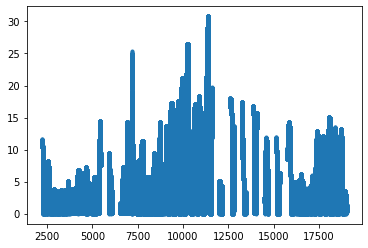

In [8]:
plt.plot(df['sec_from_start'],
         df['depth'],'.')

# Look at the Dataset

In [9]:
display(df.head())
display(df.tail())

,time,depth,Ax,Ay,Az,sec_from_start,hr_from_start
111550,2019-09-02 13:20:00.000,11.576368,0.373372,0.526533,-0.446644,2231.00,0.619722
111551,2019-09-02 13:20:00.020,11.576368,0.460187,0.382922,-0.538189,2231.02,0.619728
111552,2019-09-02 13:20:00.040,11.545249,0.562334,0.226090,-0.335575,2231.04,0.619733
111553,2019-09-02 13:20:00.060,11.545249,0.289302,0.317513,-0.558828,2231.06,0.619739
111554,2019-09-02 13:20:00.080,11.545249,0.069939,0.373697,-0.775976,2231.08,0.619744


,time,depth,Ax,Ay,Az,sec_from_start,hr_from_start
767122,2019-09-02 17:59:59.920,1.244771,-0.040391,0.415364,-0.113700,19030.92,5.286367
767123,2019-09-02 17:59:59.940,1.307009,-0.022322,0.542322,-0.248833,19030.94,5.286372
767124,2019-09-02 17:59:59.960,1.338129,0.037942,0.551322,-0.076925,19030.96,5.286378
767125,2019-09-02 17:59:59.980,1.213651,-0.001219,0.545397,-0.020830,19030.98,5.286383
767126,2019-09-02 18:00:00.000,1.307009,-0.076228,0.427457,-0.262894,19031.00,5.286389


In [10]:
# Note that observation error is approximately 0.05 (median diff)
print(df[['Ax','Ay','Az']].diff().abs().describe())

                 Ax            Ay            Az
count  6.555760e+05  6.555760e+05  6.555760e+05
mean   1.754394e-01  1.701780e-01  2.245826e-01
std    5.724601e-01  6.147045e-01  6.531886e-01
min    2.694729e-07  1.555651e-07  1.904853e-07
25%    2.400167e-02  2.814276e-02  3.384908e-02
50%    5.597958e-02  6.644568e-02  7.813137e-02
75%    1.339682e-01  1.561335e-01  1.797448e-01
max    4.664769e+01  6.721167e+01  3.846556e+01


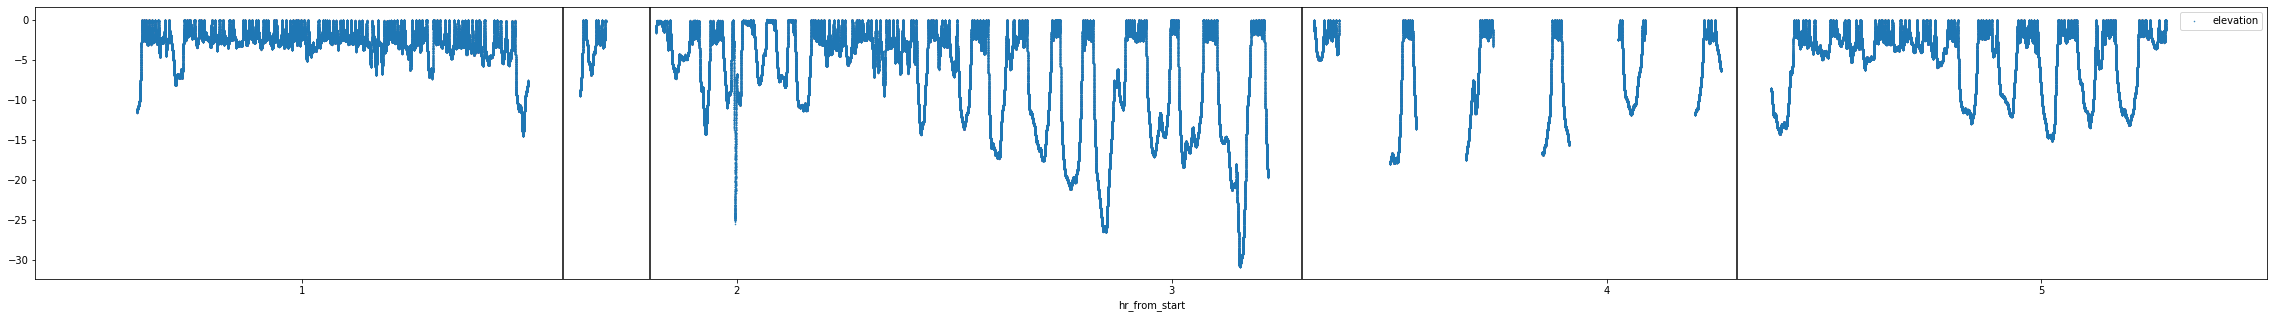

In [12]:
df['elevation'] = -df['depth']
df.plot(style='.',x='hr_from_start',y='elevation',figsize=(40,5),markersize = '1')
plt.axvline(1.6,color='k')
plt.axvline(1.8,color='k')
plt.axvline(3.3,color='k')
plt.axvline(4.3,color='k')
plt.savefig('raw_data.png')

# Preprocess and Smooth Data

In [13]:
#label which time series we are looking at

df = df[(df['hr_from_start'] < 1.6) | (df['hr_from_start'] > 1.8)]
df = df[(df['hr_from_start'] < 3.3) | (df['hr_from_start'] > 4.3)]

def get_time_series(x):
    if x < 1.6:
        return 0
    elif x < 3.3:
        return 1
    else:
        return 2
    
df['time_series'] = df['hr_from_start'].apply(get_time_series)

In [14]:
#display(df.head())
df['Vz'] = (df['depth'].shift(1) - df['depth'].shift(-1))/0.04
df['Vz'].iloc[0] = df['Vz'].iloc[1]
df['Vz'].iloc[-1] = df['Vz'].iloc[-2]

In [15]:
df['A'] = np.sqrt(np.square(df['Ax']-df['Ax'].mean()) + \
                  np.square(df['Ay']-df['Ay'].mean()) + \
                  np.square(df['Az']-df['Az'].mean()))

In [16]:
smoother = [0.2,0.2,0.2,0.2,0.2] # 1/10th of a second window
smoothing_columns = ['Ax','Ay','Az','Vz','depth']

for col in smoothing_columns:
    new_col = []
    for time_series in range(3):
        new_col.extend(list(df[df['time_series'] == time_series][col].iloc[[0,1]]))
        new_col.extend(list(convolve(smoother,
                                df[df['time_series'] == time_series][col]))[4:-4])
        new_col.extend(list(df[df['time_series'] == time_series][col].iloc[[-2,-1]]))

    df[col] = new_col

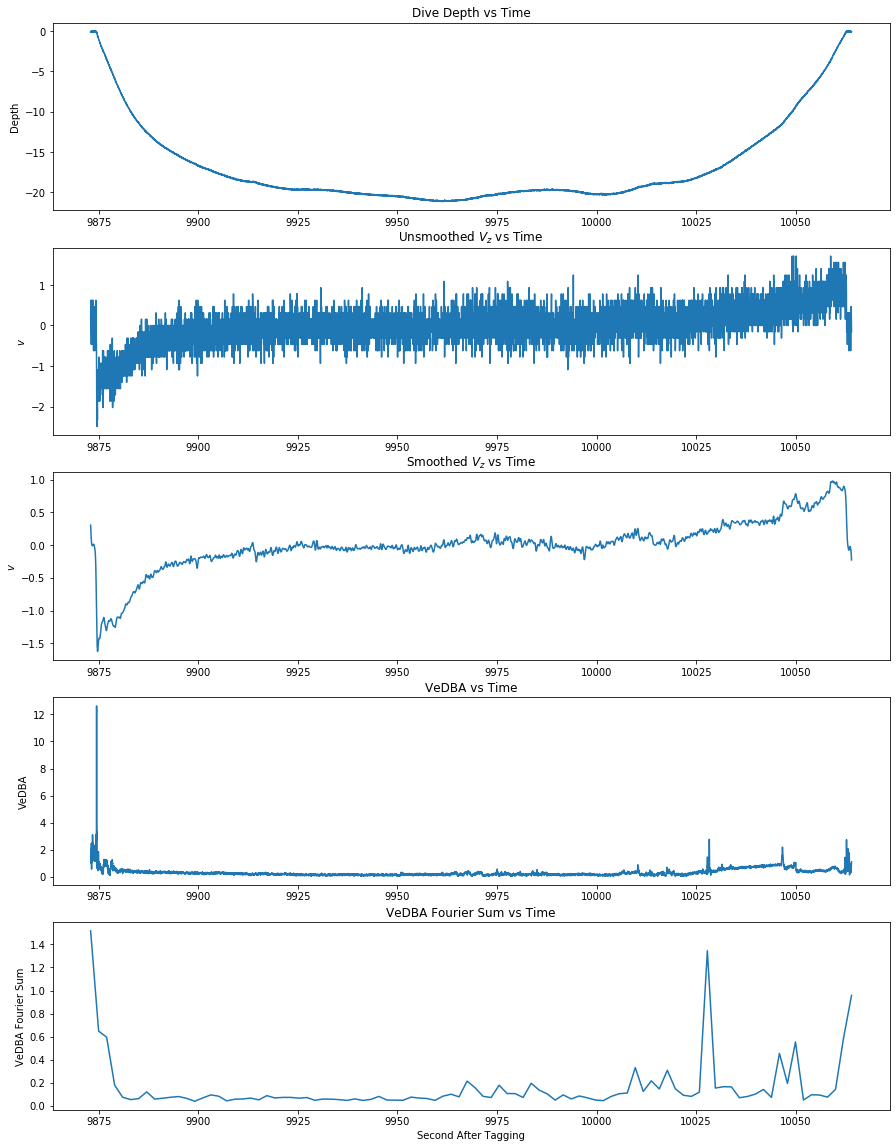

In [17]:
smoother = norm.pdf(np.linspace(-3,3,51))
smoother = smoother/sum(smoother)

new_col = []
for time_series in range(3):
    overflow = int((51-1)/2)
    new_col0 = []
    new_col0.extend([0]*25)
    new_col0.extend(list(convolve(smoother,
                            df[df['time_series'] == time_series]['Vz']))[50:-50])
    new_col0.extend([0]*25)
    
    
    for i in range(overflow):
        new_col0[i] = new_col0[overflow]
        new_col0[-(i+1)] = new_col0[-overflow-1]
    
    new_col.extend(new_col0)


start = 329100
end = 338650
    
df['sec_from_start'] = df['hr_from_start']*3600
plt.subplots(5,1,figsize=(15,20))
plt.subplot(5,1,1)

plt.plot(df['sec_from_start'].iloc[start:end],df['elevation'].iloc[start:end])
plt.title('Dive Depth vs Time')
plt.ylabel('Depth')

plt.subplot(5,1,2)
plt.plot(df['sec_from_start'].iloc[start:end],df['Vz'].iloc[start:end])
plt.title('Unsmoothed $V_z$ vs Time')
plt.ylabel(r'$v$')

df['Vz'] = new_col
plt.subplot(5,1,3)
plt.plot(df['sec_from_start'].iloc[start:end],df['Vz'].iloc[start:end])
plt.title('Smoothed $V_z$ vs Time')
plt.ylabel(r'$v$')

plt.subplot(5,1,4)
plt.plot(df['sec_from_start'].iloc[start:end],df['A'].iloc[start:end])
plt.title('VeDBA vs Time')
plt.ylabel('VeDBA')

ft = stft(df['A'].iloc[start:end],detrend='constant',nperseg=nperseg,noverlap=0,boundary=None)

# find how to add components of acceleration
freqs = ft[0]*50 #50 is the frequency in hertz
high_freq_ind = max(np.where(ft[0]*50 <= low_high_cutoff)[0]) + 1
ft_low = np.sum(np.absolute(ft[2].T)[:,:high_freq_ind],1)

plt.subplot(5,1,5)
plt.plot(np.linspace(df['sec_from_start'].iloc[start],
                     df['sec_from_start'].iloc[end],
                     len(ft_low)),
         ft_low)
plt.title('VeDBA Fourier Sum vs Time')
plt.xlabel('Second After Tagging')
plt.ylabel('VeDBA Fourier Sum')

plt.savefig('smoothed_v.png')

# Add Individual Dive Data and Visualize

In [18]:
raw_data = divebomb.profile_dives(df,
                                  minimal_time_between_dives=10, 
                                  surface_threshold=3.1,
                                  ipython_display_mode=False)

In [52]:
dives = raw_data[0]
dives = pd.merge(dives,
                 raw_data[2][['time','time_series']].rename(columns={'time':'bottom_start'}).drop_duplicates(),
                 on='bottom_start')

dives = dives.drop(len(dives)-1)
dives = dives.drop(0)
dives = dives[dives['td_total_duration'] < 1000]
dives = dives.reset_index().drop(columns=['index'])

In [53]:
df_temp = raw_data[2]
df_temp = df_temp.reset_index().drop(columns=['index'])
dive_nums = pd.Series([-1]*len(df))
for dive_num,(s,e) in enumerate(zip(dives['dive_start'],dives['dive_end'])):
    ind = (df_temp['time'] > s) & (df_temp['time'] < e)
    dive_nums[ind] = dive_num
    
df_temp['dive_num'] = dive_nums
df_temp['time'] = list(df['time'])
df = df_temp.copy()
del df_temp

In [57]:
df[df['dive_num'] == 119]['depth'].max()

13.163450869420002

In [58]:
dives['max_depth'][119]

13.163450869420002

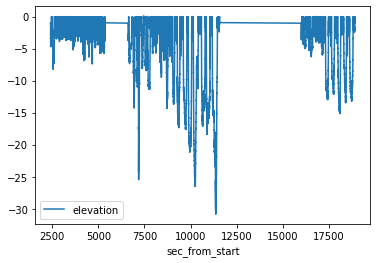

In [31]:
df[df['dive_num'] != -1].plot(x='sec_from_start',y='elevation')

In [81]:
np.fft.rfftfreq(nperseg, d=1/50)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ])

In [125]:
from scipy.signal import savgol_filter
# get relevant info from Y
Y = []
T = []
D = []
A_full = []
gbo = df.groupby('dive_num')

test_df = gbo.get_group(1).copy()
for ind in np.arange(0,len(test_df)-nperseg,nperseg):
    print(ind)
    dive_seg = test_df.iloc[ind:ind+nperseg]
    print(dive_seg['A'].var())

0
0.03667118967421807
100
0.020191859032258345
200
0.009192445869415146
300
0.006927591323107156
400
0.01363813548872466
500
0.07865383832547473
600
0.10275394624324112
700
0.11041926868836174
800
0.09896628705254452
900
0.10981226746466066
1000
0.064555472469668
1100
0.06382787794341736
1200
0.048537838708944715
1300
0.022069712957019663
1400
0.028077179644575224
1500
0.03825745566664503
1600
0.1229760147057187
1700
1.037026320815421


In [17]:
# get relevant info from Y
Y = []
T = []
D = []
A_full = []
gbo = df.groupby('dive_num')

for key in gbo.groups:
    group = gbo.get_group(key)
    inds = np.arange(0,len(group),nperseg)
    
    Y0 = group[dims].to_numpy()[:max(inds)]
    ft = stft(Y0[:,accel_ind],detrend='constant',nperseg=nperseg,noverlap=0,boundary=None)
    
    # find how to add components of acceleration
    freqs = ft[0]*50 #50 is the frequency in hertz
    high_freq_ind = max(np.where(ft[0]*50 <= low_high_cutoff)[0]) + 1
    ft_low = np.sum(np.absolute(ft[2].T)[:,:high_freq_ind],1)
    ft_high = np.sum(np.absolute(ft[2].T)[:,high_freq_ind:],1)
    
    # remove acceleration vector alone 
    Y0 = np.delete(Y0,accel_ind,1)
    
    # combine everything together
    Y0 = np.c_[Y0[::nperseg],ft_low]
    D.append(group['Elevation'].to_numpy()[:max(inds)][::nperseg])
    A_full.append(group['A'].to_numpy()[:max(inds)])
    Y.append(Y0)
    T.append(group['sec_from_start'].to_numpy()[:max(inds)][::nperseg])

#dims.remove('A')
#dims.remove('Vz')
#dims.extend(['A_freq_low'])
d = len(Y[0][0])

In [18]:
# only take all dives deeper than 20 meters
dive_nums = df[df['depth'] > 20]['dive_num'].unique()
if -1 in dive_nums:
    dive_nums = np.delete(dive_nums,np.where(dive_nums == -1)[0][0])
if 111 in dive_nums:
    dive_nums = np.delete(dive_nums,np.where(dive_nums == 111)[0][0])
Y_downsampled = [Y[i+1] for i in dive_nums]
T_downsampled = [T[i+1] for i in dive_nums]
D_downsampled = [D[i+1] for i in dive_nums]
A_downsampled = [A_full[i+1] for i in dive_nums]

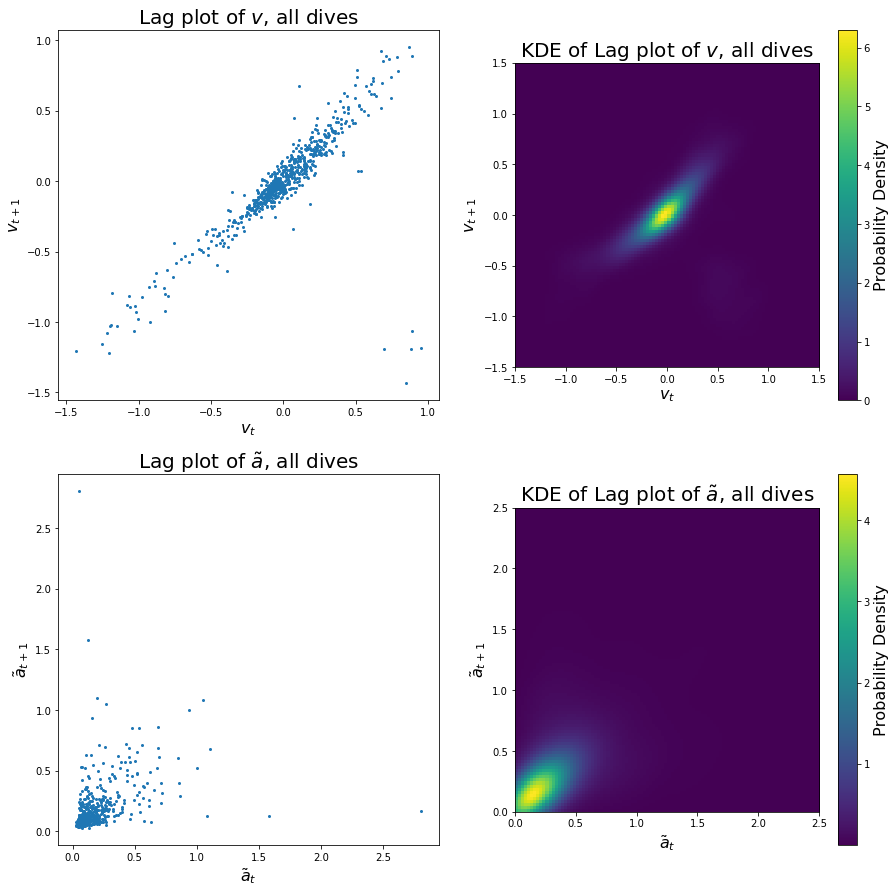

In [19]:
plt.subplots(2,2,figsize = (15,15))
plt.subplot(2,2,1)
plt.plot(np.concatenate(Y_downsampled)[:-1,0],
         np.concatenate(Y_downsampled)[1:,0],'.',markersize=4)
plt.title(r'Lag plot of $v$, all dives',fontsize = 20)
plt.xlabel(r'$v_{t}$',fontsize = 16)
plt.ylabel(r'$v_{t+1}$',fontsize = 16)

plt.subplot(2,2,2)
kernel = gaussian_kde([np.concatenate(Y)[:-1,0],np.concatenate(Y)[1:,0]])
Xtemp, Ytemp = np.mgrid[-1.5:1.5:100j, -1.5:1.5:100j]
positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
Ztemp = np.reshape(kernel(positions).T, Xtemp.shape)
plt.imshow(np.rot90(Ztemp),extent = [-1.5,1.5,-1.5,1.5])
plt.title(r'KDE of Lag plot of $v$, all dives',fontsize = 20)
plt.xlabel(r'$v_{t}$',fontsize = 16)
plt.ylabel(r'$v_{t+1}$',fontsize = 16)
c = plt.colorbar()
c.set_label('Probability Density',fontsize = 16)



plt.subplot(2,2,3)
plt.plot(np.concatenate(Y_downsampled)[:-1,1],
         np.concatenate(Y_downsampled)[1:,1],'.',markersize=4)
plt.title(r'Lag plot of $\tilde a$, all dives',fontsize = 20)
plt.xlabel(r'$\tilde a_{t}$',fontsize = 16)
plt.ylabel(r'$\tilde a_{t+1}$',fontsize = 16)

plt.subplot(2,2,4)
kernel = gaussian_kde([np.concatenate(Y)[:-1,1],np.concatenate(Y)[1:,1]])
Xtemp, Ytemp = np.mgrid[0:2.5:100j, 0:2.5:100j]
positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
Ztemp = np.reshape(kernel(positions).T, Xtemp.shape)
plt.imshow(np.rot90(Ztemp),extent = [0,2.5,0,2.5])
plt.title(r'KDE of Lag plot of $\tilde a$, all dives',fontsize = 20)
plt.xlabel(r'$\tilde a_{t}$',fontsize = 16)
plt.ylabel(r'$\tilde a_{t+1}$',fontsize = 16)
c = plt.colorbar()
c.set_label('Probability Density',fontsize = 16)
plt.savefig('lagplot.png')

# Define Likelihood and Optimize

In [20]:
def likelihood_p(Y,eta,theta,
                 drop_dive=(-1,-1),
                 cdf_dim=-1,
                 emissions=np.array(['normal']),
                 corr_inds = [0]):
    
    # Find number of states
    N = eta.shape[0]
    
    # norm indices
    if np.all(emissions == 'normal'):
        norm_inds = np.array(range(len(Y[0][0])))
        gamm_inds = np.array([])
    elif np.all(emissions == 'gamma'):
        norm_inds = np.array([])
        gamm_inds = np.array(range(len(Y[0][0])))
    else:
        norm_inds = np.where(emissions == 'normal')[0]
        gamm_inds = np.where(emissions == 'gamma')[0]
    
    # find the tpm
    eta[np.diag_indices(N)] = 0
    ptm = np.exp(eta)
    ptm = (ptm.T/np.sum(ptm,1)).T
    
    # find the initial distribution (stationary distribution)
    delta = np.ones((1,N))/N
    for _ in range(10):
        delta = delta.dot(ptm)
    
    mu_RL = np.array(theta[:,:,0])
    sigma = np.array(theta[:,:,1])
    corr = np.array(expit(theta[:,:,2]))
    
    # overall likelihood
    L_p = 0
    
    # iterate through all of the dives
    for i,Y0 in enumerate(Y):
            
        # initialize values
        phi = delta
        L_p0 = 0
        y_tm1 = 0
        
        # iterate through each time step
        for j,y_t in enumerate(Y0):
            
            mu_t = np.array(mu_RL)
            
            if j != 0:
                for ind in corr_inds:
                    mu_t[:,ind] = (1.0-corr[:,ind])*mu_RL[:,ind] + corr[:,ind]*y_tm1[ind]
                
            shape_t = np.square(mu_t)/np.square(sigma)
            scale_t = np.square(sigma)/np.array(mu_t)
            
            # skip dives to use for psuedoresiduals
            if i == drop_dive[0] and j == drop_dive[1]:
                if cdf_dim != -1:
                    
                    if emissions[cdf_dim] == 'normal':
                        F_yt_given_xt = norm.cdf(y_t[cdf_dim],mu_t[:,cdf_dim],sigma[:,cdf_dim])
                    else:
                        F_yt_given_xt = gamma.cdf(y_t[cdf_dim],shape_t[:,cdf_dim],0,scale_t[:,cdf_dim])
                        
                    v = phi.dot(ptm)*F_yt_given_xt
                else:
                    v = phi.dot(ptm)
                    
            # find the transition and emission step for all other dives
            else:
                
                if len(norm_inds) > 0:
                    y_norm = np.take(y_t,norm_inds)
                    mu_norm = np.take(mu_t,norm_inds,axis=1)
                    sigma_norm = np.take(sigma,norm_inds,axis=1)
                    p_yt_given_xt_norm = np.prod(norm.pdf(y_norm,mu_norm,sigma_norm),1)
                else:
                    p_yt_given_xt_norm = 1.0
                    
                if len(gamm_inds) > 0:
                    y_gamm = np.take(y_t,gamm_inds)
                    shape_gamm = np.take(shape_t,gamm_inds,axis=1)
                    scale_gamm = np.take(scale_t,gamm_inds,axis=1)
                    p_yt_given_xt_gamm = np.prod(gamma.pdf(y_gamm,shape_gamm,0,scale_gamm),1)
                else:
                    p_yt_given_xt_gamm = 1.0
                    
                p_yt_given_xt = p_yt_given_xt_norm*p_yt_given_xt_gamm
                v = phi.dot(ptm)*p_yt_given_xt
            
            # add log-likelihood and adjust for vanishing gradients
            u = np.sum(v)
            L_p0 += np.log(u)
            phi = v/u
            
            y_tm1 = y_t
            
        L_p += L_p0

    return L_p

In [21]:
N = 3
emissions=np.array(['normal','gamma'])
corr_inds=[0]

# initial guesses for theta
mu_RL0 = 0.01*np.random.normal(size=(N,d))
sigma0 = 0.01*np.random.normal(size=(N,d))
corr0 = -1 + 0.001*np.random.normal(size=(N,d))
theta = np.zeros(shape=(N,d,3))

mu_RL0[:,0] += [-0.5,0.0,0.5] #np.mean(Y_downsampled[1],0)[0] # mean of Vz
sigma0[:,0] += [0.5,0.5,0.5] #np.std(Y_downsampled[1],0)[0] # std of Vz
#corr0[:,0] *= 1.0 # correlation for Vz

mu_RL0[:,1] += [1.0,0.1,1.0] # mean of Alow
sigma0[:,1] += [1.0,0.1,1.0]# std of Alow
#corr0[:,1] *= 1.0 # correlation for Alow

#mu_RL0[:,2] *= np.mean(Y_downsampled[1],0)[2] # mean of Ahigh
#sigma0[:,2] *= np.std(Y_downsampled[1],0)[2] # std of Ahigh
#corr0[:,2] *= 1.0 # correlation for Ahigh

theta[:,:,0] = mu_RL0
theta[:,:,1] = sigma0
theta[:,:,2] = corr0

# randomly initialize the ptm
eta = -1.0 + np.random.normal(size=(N,N))

# time the likelihood evaluation time
start = time.time()
l = likelihood_p([Y_downsampled[1]],eta,theta,emissions=np.array(['normal','gamma']))
end = time.time()
print(end - start)
print(l)

0.038736820220947266
25.7032497885175


In [22]:
def loss_fn(x):
    eta = x[:N**2].reshape((N,N))
    theta = np.reshape(x[N**2:],(N,d,3))
    return -likelihood_p(Y_downsampled,eta,theta,
                         emissions=emissions,
                         corr_inds=corr_inds)

# note there are better and faster ways to do this, notably with the baum-welch algorithm, but
# 5 minutes is okay with me, and the results look alright

# try to load what has been saved
try:
    with open('../Data/naive_params_Vz_Afreq_CarHMM_N%d_new.pkl' % N, 'rb') as f:
        res = pickle.load(f)
        
# if nothing has been saved, find parameters again
except FileNotFoundError:
    print('yikes')
    x0 = np.concatenate([eta.ravel(),theta.ravel()])
    start = time.time()
    res = minimize(loss_fn, x0, method='Nelder-Mead', options={'disp': True, 'adaptive':True})
    end = time.time()
    print(end - start)

    with open('../Data/naive_params_Vz_Afreq_CarHMM_N%d_new.pkl' % N, 'wb') as f: 
        pickle.dump(res, f)

yikes
1335.384084224701


# Visualize the Results

Probability Transition Matrix:
[[7.93213675e-01 2.05997144e-01 7.89181377e-04]
 [1.23406368e-01 8.76266991e-01 3.26640927e-04]
 [6.01637659e-01 1.26081447e-03 3.97101526e-01]]

Stationary Distribution:
[[0.3847741  0.61434879 0.00087711]]

Means:
[[-1.2278074   0.28303717]
 [-0.01065878  0.07665449]
 [-1.62726094  2.2856699 ]]

Variances:
[[0.12614387 0.18534236]
 [0.05756567 0.02413334]
 [0.04604037 0.48433731]]

Autocorrelation:
[[9.92233370e-01 6.05823039e-04]
 [8.95116665e-01 9.56118936e-01]
 [9.34814777e-01 5.69408505e-07]]



/home/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/home/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/home/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reu

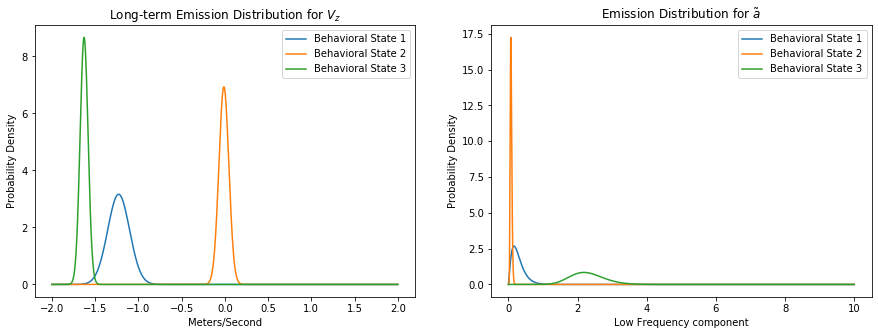

In [23]:
eta = res['x'][:N**2].reshape((N,N))
theta = np.reshape(res['x'][N**2:],(N,d,3))

eta = np.array(eta)
theta = np.array(theta)

eta[np.diag_indices(N)] = 0

ptm = np.exp(eta)
ptm = (ptm.T/np.sum(ptm,1)).T

delta = np.ones((1,N))/N
for _ in range(10):
    delta = delta.dot(ptm)

print('Probability Transition Matrix:')
print(ptm)
print('')
print('Stationary Distribution:')
print(delta)
print('')
print('Means:')
print(theta[:,:,0])
print('')
print('Variances:')
print(theta[:,:,1])
print('')
print('Autocorrelation:')
print(expit(theta[:,:,2]))
print('')

titles = [r'Long-term Emission Distribution for $V_z$',
          r'Emission Distribution for $\tilde a$']
xlabels = ['Meters/Second','Low Frequency component']
ylabels = ['Probability Density','Probability Density']

plt.subplots(1,d,figsize = (d*7.5,5))

for i,state_th in enumerate(theta):
    
    for j,dim_th in enumerate(state_th):
            
        mu = dim_th[0]
        sigma = dim_th[1]
        
        shape = np.square(mu)/np.square(sigma)
        scale = np.square(sigma)/np.array(mu)
         
        plt.subplot(1,d,j+1)
        if j == 0:
            x = np.linspace(-2,2,10000)
            y = norm.pdf(x,mu,sigma)
        else:
            x = np.linspace(0,10,10000)
            y = gamma.pdf(x,shape,0,scale)
        plt.plot(x,y)
        
        plt.title(titles[j])
        plt.xlabel(xlabels[j])
        plt.ylabel('Probability Density')
        plt.legend(['Behavioral State %d' % (k+1) for k in range(N)])
    
plt.savefig('emis_dist.png')

# Do the Virterbi Algorithm to find most likely state

In [24]:
# taken from stack-overflow
def viterbi(Y,ptm,theta, 
            emissions=np.array(['normal']),
            corr_inds = [0]):
    
    """
    Return the MAP estimate of state trajectory of Hidden Markov Model.

    Parameters
    ----------
    Y : array (T,d)
        Observation state sequence. int dtype.
    ptm : array (N, N)
        State transition matrix.
    theta : array (N, d, 2)
        Emission parameters for gamma distribution.

    Returns
    -------
    x : array (T,)
        Maximum a posteriori probability estimate of hidden state trajectory,
        conditioned on observation sequence y under the model parameters A, B,
        Pi.
    T1: array (K, T)
        the probability of the most likely path so far
    T2: array (K, T)
        the x_j-1 of the most likely path so far
    """
    
    # Find number of states
    N = eta.shape[0]
    
    # norm indices
    if np.all(emissions == 'normal'):
        norm_inds = np.array(range(len(Y[0])))
        gamm_inds = np.array([])
    elif np.all(emissions == 'gamma'):
        norm_inds = np.array([])
        gamm_inds = np.array(range(len(Y[0])))
    else:
        norm_inds = np.where(emissions == 'normal')[0]
        gamm_inds = np.where(emissions == 'gamma')[0]
    
    # find the tpm
    eta[np.diag_indices(N)] = 0
    ptm = np.exp(eta)
    ptm = (ptm.T/np.sum(ptm,1)).T
    
    # find the initial distribution (stationary distribution)
    delta = np.ones((1,N))/N
    for _ in range(10):
        delta = delta.dot(ptm)
    
    mu_RL = np.array(theta[:,:,0])
    sigma = np.array(theta[:,:,1])
    corr = np.array(expit(theta[:,:,2]))
    
    # Initilaize the tracking tables from first observation
    T = Y.shape[0]
    T1 = np.zeros((T,N)) # probs of most likely
    T2 = np.zeros((T,N)) # most likely state
    
    mu_t = np.array(mu_RL)
    shape_t = np.square(mu_t)/np.square(sigma)
    scale_t = np.square(sigma)/np.array(mu_t)
    
    if len(norm_inds) > 0:
        y_norm = np.take(Y[0],norm_inds)
        mu_norm = np.take(mu_t,norm_inds,axis=1)
        sigma_norm = np.take(sigma,norm_inds,axis=1)
        p_y0_given_x0_norm = np.prod(norm.pdf(y_norm,mu_norm,sigma_norm),1)
    else:
        p_y0_given_x0_norm = 1.0

    if len(gamm_inds) > 0:
        y_gamm = np.take(Y[0],gamm_inds)
        shape_gamm = np.take(shape_t,gamm_inds,axis=1)
        scale_gamm = np.take(scale_t,gamm_inds,axis=1)
        p_y0_given_x0_gamm = np.prod(gamma.pdf(y_gamm,shape_gamm,0,scale_gamm),1)
    else:
        p_y0_given_x0_gamm = 1.0

    log_p_y0_given_x0 = np.log(p_y0_given_x0_norm) + np.log(p_y0_given_x0_gamm)

    T1[0,:] = np.log(delta) + log_p_y0_given_x0
    T2[0,:] = -1

    # Iterate throught the observations updating the tracking tables
    for t in range(1,T):
        
        mu_t[:,0] = (1.0-corr[:,0])*mu_RL[:,0] + corr[:,0]*Y[t-1][0]
        shape_t = np.square(mu_t)/np.square(sigma)
        scale_t = np.square(sigma)/np.array(mu_t)
        
        if len(norm_inds) > 0:
            y_norm = np.take(Y[t],norm_inds)
            mu_norm = np.take(mu_t,norm_inds,axis=1)
            sigma_norm = np.take(sigma,norm_inds,axis=1)
            p_yt_given_xt_norm = np.prod(norm.pdf(y_norm,mu_norm,sigma_norm),1)
        else:
            p_yt_given_xt_norm = 1.0

        if len(gamm_inds) > 0:
            y_gamm = np.take(Y[t],gamm_inds)
            shape_gamm = np.take(shape_t,gamm_inds,axis=1)
            scale_gamm = np.take(scale_t,gamm_inds,axis=1)
            p_yt_given_xt_gamm = np.prod(gamma.pdf(y_gamm,shape_gamm,0,scale_gamm),1)
        else:
            p_yt_given_xt_gamm = 1.0

        log_p_yt_given_xt = np.log(p_yt_given_xt_norm) + np.log(p_yt_given_xt_gamm)
        
        for i in range(N):
            
            T1[t,i] = np.max(T1[t-1,:] + np.log(ptm[:,i]) + log_p_yt_given_xt[i])
            T2[t,i] = np.argmax(T1[t-1,:] + np.log(ptm[:,i]))

    # Build the output, optimal model trajectory
    x = -1 * np.ones(T)
    x[-1] = np.argmax(T1[T-1,:])
    for t in reversed(range(1, T)):
        x[t-1] = T2[t, int(x[t])]

    return x, T1, T2

s_hat = []
T1 = []
T2 = []

for i,Y0 in enumerate(Y):
    s_hat0,T10,T20 = viterbi(Y0,ptm,theta,
                             emissions=emissions,
                             corr_inds=corr_inds)
    
    s_hat.append(s_hat0)
    T1.append(T10)
    T2.append(T20)
    Y[i] = np.append(Y0,np.array(s_hat0,ndmin=2).T,axis=1)

s_hat_downsampled = []
T1_downsampled = []
T2_downsampled = []

for i,Y0 in enumerate(Y_downsampled):
    s_hat0,T10,T20 = viterbi(Y0,ptm,theta,
                             emissions=emissions,
                             corr_inds=corr_inds)
    
    s_hat_downsampled.append(s_hat0)
    T1_downsampled.append(T10)
    T2_downsampled.append(T20)
    Y_downsampled[i] = np.append(Y0,np.array(s_hat0,ndmin=2).T,axis=1)

/home/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: RuntimeWarning:

divide by zero encountered in log

/home/evsi8432/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning:

divide by zero encountered in log



# Visualize the state over time

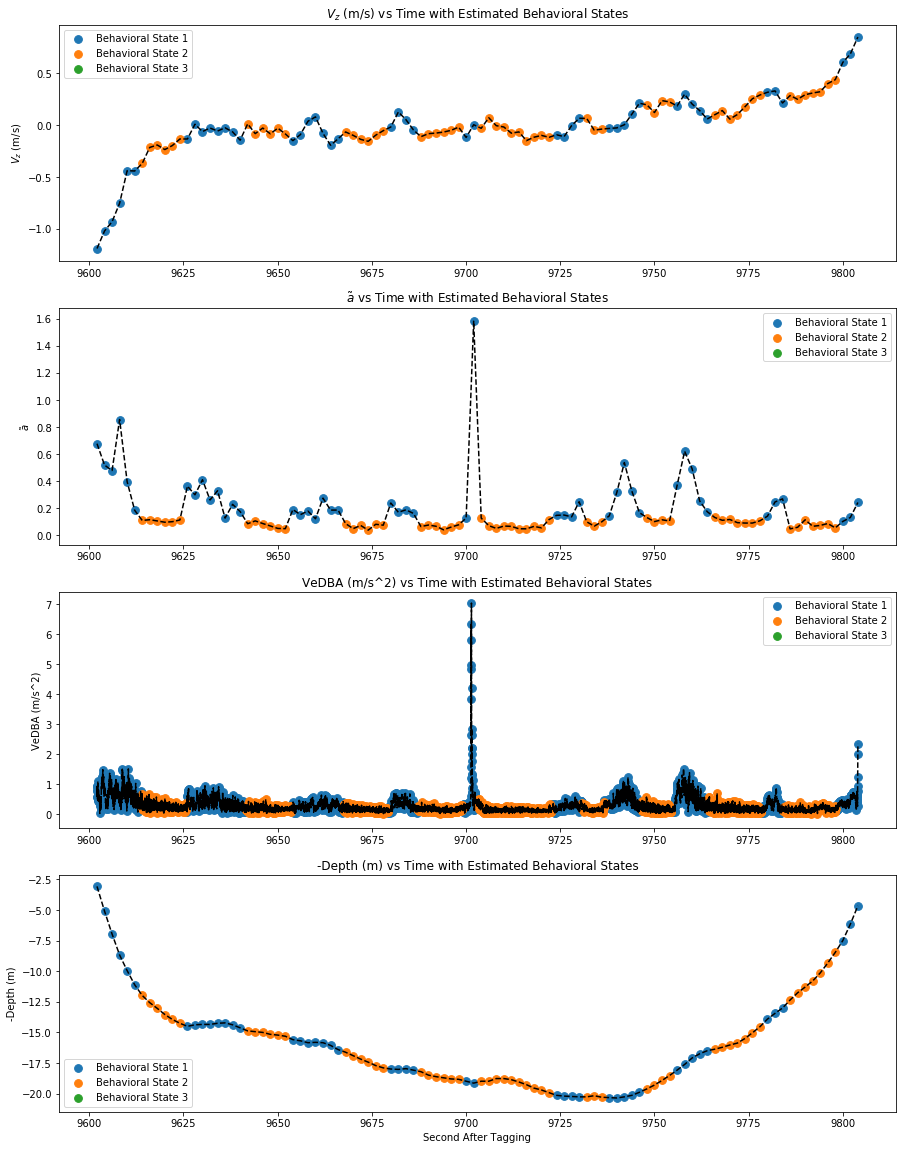

In [25]:
dive_num = 1

d=2
plt.subplots(4,1,figsize=(15,20))

ylabels = [r'$V_z$ (m/s)',r'$\tilde a$','VeDBA (m/s^2)','-Depth (m)']
YA = [np.repeat(y[:,-1],100) for y in Y_downsampled]
TA = np.linspace(min(T_downsampled[dive_num]),
                 max(T_downsampled[dive_num]),
                 len(A_downsampled[dive_num]))

for i in range(d+2):
    plt.subplot(d+2,1,i+1)
    
    for j,color in enumerate(['tab:blue', 'tab:orange', 'tab:green']):
        
        depth = np.take(D_downsampled[dive_num],
                        np.where(Y_downsampled[dive_num][:,-1]==j)[0],axis=0)
        t = np.take(T_downsampled[dive_num],
                    np.where(Y_downsampled[dive_num][:,-1]==j)[0],axis=0)
        y = np.take(Y_downsampled[dive_num],
                    np.where(Y_downsampled[dive_num][:,-1]==j)[0],axis=0)
        a = np.take(A_downsampled[dive_num],
                    np.where(YA[dive_num]==j)[0],axis=0)
        ta = np.take(TA,np.where(YA[dive_num]==j)[0],axis=0)
        
        if i < d:
            plt.scatter(t,y[:,i],c=color,s=60)
        elif i == d:
            plt.scatter(ta,a,c=color,s=60)
        else:
            plt.scatter(t,depth,c=color,s=60)
    
    plt.legend(['Behavioral State %d' % (x+1) for x in range(N)]) 
    if i < d:
        plt.plot(T_downsampled[dive_num],Y_downsampled[dive_num][:,i],'k--')
    elif i == d:
        plt.plot(TA,A_downsampled[dive_num],'k--')
    else:
        plt.plot(T_downsampled[dive_num],D_downsampled[dive_num],'k--')
        plt.xlabel("Second After Tagging")
        
    plt.ylabel(ylabels[i])
    plt.title("%s vs Time with Estimated Behavioral States" % ylabels[i])
    plt.savefig("viterbi.png")

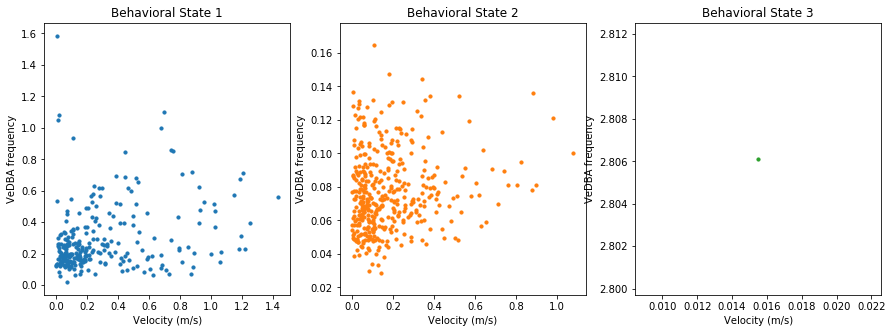

In [26]:
plt.subplots(1,3,figsize=(15,5))
for j,color in enumerate(['tab:blue', 'tab:orange', 'tab:green']):
    y = np.take(np.concatenate(Y_downsampled),
                np.where(np.concatenate(Y_downsampled)[:,-1]==j)[0],axis=0)
    
    plt.subplot(1,3,j+1)
    plt.scatter(np.abs(y[:,0]),y[:,1],c=color,s=10)
    
    plt.title('Behavioral State %d' % (j+1))
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('VeDBA frequency')
plt.savefig("viterbi_corr.png")

# Use the forward-backward algorithm to get state probabilities

In [27]:
def fwd_bwd(Y,eta,theta,emissions=np.array(['normal']),corr_inds = [0]):
    
    # Find number of states
    N = eta.shape[0]
    T = len(Y)
    
    # norm indices
    if np.all(emissions == 'normal'):
        norm_inds = np.array(range(len(Y[0][0])))
        gamm_inds = np.array([])
    elif np.all(emissions == 'gamma'):
        norm_inds = np.array([])
        gamm_inds = np.array(range(len(Y[0][0])))
    else:
        norm_inds = np.where(emissions == 'normal')[0]
        gamm_inds = np.where(emissions == 'gamma')[0]
    
    # find the tpm
    eta[np.diag_indices(N)] = 0
    ptm = np.exp(eta)
    ptm = (ptm.T/np.sum(ptm,1)).T
    
    # find the initial distribution (stationary distribution)
    delta = np.ones((1,N))/N
    for _ in range(10):
        delta = delta.dot(ptm)
    
    mu_RL = np.array(theta[:,:,0])
    sigma = np.array(theta[:,:,1])
    corr = np.array(expit(theta[:,:,2]))
    
    # overall likelihood
    L_alpha = 0
    L_beta = 0
            
    # initialize values
    alpha_scaled = np.zeros((N,T))
    alpha_scaled[:,0] = delta
    
    beta_scaled = np.zeros((N,T))
    beta_scaled[:,-1] = np.ones(N)

    # forward algorithm
    for t,y_t in enumerate(Y):

        mu_t = np.array(mu_RL)

        if t != 0:
            for ind in corr_inds:
                mu_t[:,ind] = (1.0-corr[:,ind])*mu_RL[:,ind] + corr[:,ind]*y_tm1[ind]
        
        shape_t = np.square(mu_t)/np.square(sigma)
        scale_t = np.square(sigma)/np.array(mu_t)

        if len(norm_inds) > 0:
            y_norm = np.take(y_t,norm_inds)
            mu_norm = np.take(mu_t,norm_inds,axis=1)
            sigma_norm = np.take(sigma,norm_inds,axis=1)
            p_yt_given_xt_norm = np.prod(norm.pdf(y_norm,mu_norm,sigma_norm),1)
        else:
            p_yt_given_xt_norm = 1.0

        if len(gamm_inds) > 0:
            y_gamm = np.take(y_t,gamm_inds)
            shape_gamm = np.take(shape_t,gamm_inds,axis=1)
            scale_gamm = np.take(scale_t,gamm_inds,axis=1)
            p_yt_given_xt_gamm = np.prod(gamma.pdf(y_gamm,shape_gamm,0,scale_gamm),1)
        else:
            p_yt_given_xt_gamm = 1.0

        p_yt_given_xt = p_yt_given_xt_norm*p_yt_given_xt_gamm

        # add log-likelihood and adjust for vanishing gradients
        v = alpha_scaled[:,t].dot(ptm)*p_yt_given_xt
        u = np.sum(v)
        L_alpha += np.log(u)
        if t != len(Y)-1:
            alpha_scaled[:,t+1] = v/u
            y_tm1 = y_t

    # backward algorithm
    beta_scaled[:,-1] = np.ones_like(delta)
    
    for t,y_t in enumerate(reversed(Y)):
        
        mu_t = np.array(mu_RL)

        if t != len(Y)-1:
            y_tm1 = Y[-t-2]
            for ind in corr_inds:
                mu_t[:,ind] = (1.0-corr[:,ind])*mu_RL[:,ind] + corr[:,ind]*y_tm1[ind]

        shape_t = np.square(mu_t)/np.square(sigma)
        scale_t = np.square(sigma)/np.array(mu_t)

        if len(norm_inds) > 0:
            y_norm = np.take(y_t,norm_inds)
            mu_norm = np.take(mu_t,norm_inds,axis=1)
            sigma_norm = np.take(sigma,norm_inds,axis=1)
            p_yt_given_xt_norm = np.prod(norm.pdf(y_norm,mu_norm,sigma_norm),1)
        else:
            p_yt_given_xt_norm = 1.0

        if len(gamm_inds) > 0:
            y_gamm = np.take(y_t,gamm_inds)
            shape_gamm = np.take(shape_t,gamm_inds,axis=1)
            scale_gamm = np.take(scale_t,gamm_inds,axis=1)
            p_yt_given_xt_gamm = np.prod(gamma.pdf(y_gamm,shape_gamm,0,scale_gamm),1)
        else:
            p_yt_given_xt_gamm = 1.0

        p_yt_given_xt = p_yt_given_xt_norm*p_yt_given_xt_gamm

        # add log-likelihood and adjust for vanishing gradients
        if t != len(Y)-1:
            v = (ptm*p_yt_given_xt).dot(beta_scaled[:,-t-1])
            u = np.sum(v)
            L_beta += np.log(u)
            beta_scaled[:,-t-2] = v/u
        else:
            v = (delta*p_yt_given_xt).dot(beta_scaled[:,-t-1])
            u = np.sum(v)
            L_beta += np.log(u)
        
    # Merging the two parts
    posterior = np.zeros((N,T))
    for t in range(T):
        posterior[:,t] = alpha_scaled[:,t] * beta_scaled[:,t]
        posterior[:,t] = posterior[:,t] / sum(posterior[:,t])
    
    #assert L_alpha == L_beta
        
    return alpha_scaled, beta_scaled, posterior

In [28]:
#fwd_bwd(Y_downsampled[1],eta,theta,emissions=np.array(['normal','gamma']))
likelihood_p(np.array([Y_downsampled[1]]),eta,theta,emissions=np.array(['normal','gamma']))

213.5940746849723

In [29]:
_,_,posterior = fwd_bwd(np.array(Y_downsampled[1]),eta,theta,emissions=np.array(['normal','gamma']))

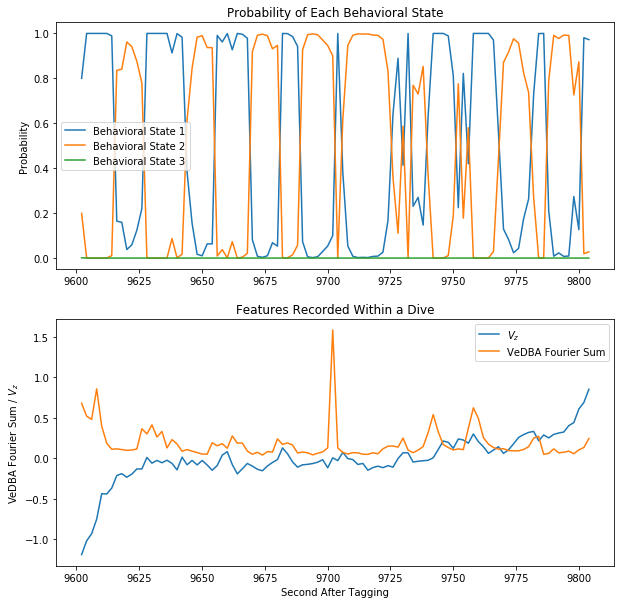

In [30]:
plt.subplots(2,1,figsize=(10,10))

plt.subplot(2,1,1)
plt.plot(T_downsampled[1],posterior.T)
plt.title('Probability of Each Behavioral State')
plt.ylabel('Probability')
plt.legend(['Behavioral State %d' % x for x in [1,2,3]])

plt.subplot(2,1,2)
plt.plot(T_downsampled[1],Y_downsampled[1][:,0:2])
plt.title('Features Recorded Within a Dive')
plt.ylabel(r'VeDBA Fourier Sum / $V_z$')
plt.xlabel('Second After Tagging')
plt.legend([r'$V_z$','VeDBA Fourier Sum'])